In [27]:
import os
import glob
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
    
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_directory = "./data/CEBS/m001"
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_db = 5

segment_size = '10S'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

num_epochs = 100
batch_size = 4
learning_rate = 0.001

In [29]:
def signaltonoise_dB(signal_clean, signal_noisy):
    signal_clean_watts = signal_clean ** 2
    signal_clean_avg_watts = np.mean(signal_clean_watts)
    signal_clean_avg_db = 10 * np.log10(signal_clean_avg_watts)

    noise = signal_noisy - signal_clean
    noise_watts = noise ** 2
    noise_avg_watts = np.mean(noise_watts)
    noise_avg_db = 10 * np.log10(noise_avg_watts)

    return signal_clean_avg_db - noise_avg_db

In [30]:
def load_dataset(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    # frequency = metadata['fs']
    column_names = metadata['sig_name']
    # length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    # frequency_string = str(int(1/frequency*1000000)) + 'U'
    # index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    # data.set_index(index, inplace=True)
    # data.resample(sampling_rate).mean().SCG
    
    return data

In [31]:
def load_datasets(directory):

    filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*[0-9][0-9][0-9].*')]))
    data = pd.concat((load_dataset(filename) for filename in filenames), ignore_index=True)

    frequency = 5000
    length = data.shape[0]
    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)

    return data

In [32]:
def add_gaussian(data, target_snr_db):
    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

In [33]:
class DeNoise(nn.Module):
    def __init__(self):
        super(DeNoise, self).__init__()

        self.lin1 = nn.Linear(segment_size_samples, 500)
        self.lin_t1 = nn.Linear(500, segment_size_samples)

    def forward(self, x):
        x = torch.tanh(self.lin1(x))
        x = self.lin_t1(x)
        return x

In [48]:
class SCGData(Dataset):

    def __init__(self, transform=None):

        data = load_datasets('./data/CEBS/')
        data = data.resample(sampling_rate).mean().SCG

        data_noisy = add_gaussian(data, target_snr_db)
        data = pd.DataFrame({'clean': data, 'noise': data_noisy})
        data = data.groupby((data.index - data.index[0]).total_seconds() // segment_size_seconds).agg(list) # 1000 sec
        data = data[data['clean'].apply(lambda x: len(x) == segment_size_samples)]
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [49]:
dataset = SCGData(transform=ToTensor())

In [44]:
model = DeNoise().to(device)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
n_total_steps = len(dataloader)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(n_epochs, model):
    
    for epoch in range(n_epochs):
        trainloss = 0.0
        for i, (inputs, lables) in enumerate(dataloader):
            
            inputs = inputs.to(device)
            lables = lables.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()

            if (i + 1) % 100 == 0:
                print(f'epoch {epoch + 1} / {n_epochs}, step {i + 1} / {n_total_steps}, loss = {loss.item():.4f}')

train(num_epochs, model)

FILE = 'model.pth'
torch.save(model.state_dict(), FILE)

epoch 1 / 100, step 100 / 1792, loss = 4.9904
epoch 1 / 100, step 200 / 1792, loss = 4.8061
epoch 1 / 100, step 300 / 1792, loss = 6.1218
epoch 1 / 100, step 400 / 1792, loss = 6.7840
epoch 1 / 100, step 500 / 1792, loss = 7.6521
epoch 1 / 100, step 600 / 1792, loss = 6.6117
epoch 1 / 100, step 700 / 1792, loss = 8.0142
epoch 1 / 100, step 800 / 1792, loss = 7.8893
epoch 1 / 100, step 900 / 1792, loss = 5.3324
epoch 1 / 100, step 1000 / 1792, loss = 7.5509
epoch 1 / 100, step 1100 / 1792, loss = 4.8493
epoch 1 / 100, step 1200 / 1792, loss = 5.2883
epoch 1 / 100, step 1300 / 1792, loss = 6.9802
epoch 1 / 100, step 1400 / 1792, loss = 2.3392
epoch 1 / 100, step 1500 / 1792, loss = 2.5906
epoch 1 / 100, step 1600 / 1792, loss = 3.3358
epoch 1 / 100, step 1700 / 1792, loss = 2.6830
epoch 2 / 100, step 100 / 1792, loss = 4.4267
epoch 2 / 100, step 200 / 1792, loss = 4.6460
epoch 2 / 100, step 300 / 1792, loss = 3.6487
epoch 2 / 100, step 400 / 1792, loss = 5.0392
epoch 2 / 100, step 500 / 

7.8326404094696045
4.305621385574341


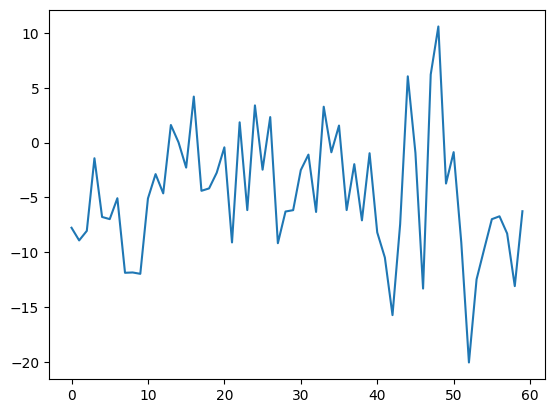

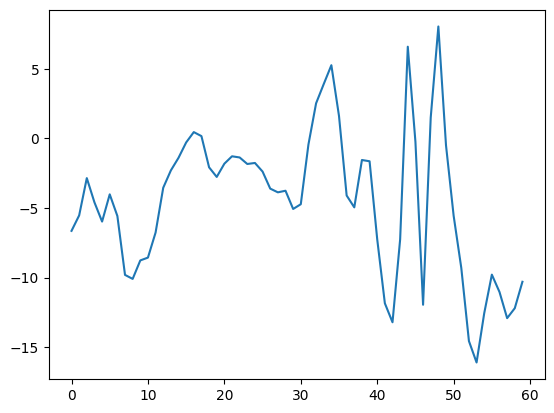

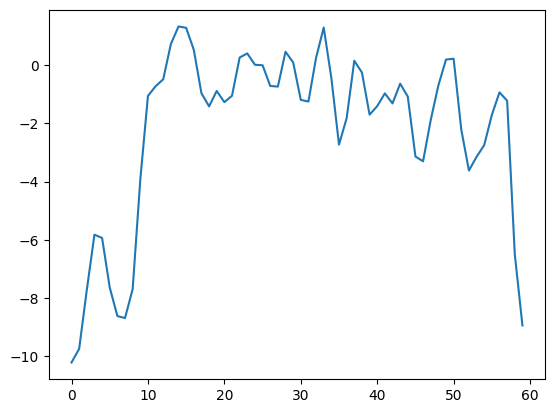

In [50]:
with torch.no_grad():

    #denoised = denoise_wavelet(data.noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
    
    noise = dataset[0][0].to(device)
    clean = dataset[0][1].to(device)

    predicted = model(noise).to('cpu').numpy()
    clean = clean.to('cpu').numpy()
    noise = noise.to('cpu').numpy()

    print(signaltonoise_dB(clean, noise))
    print(signaltonoise_dB(clean, predicted))

    time = 60
    plt.plot(range(time), noise[:time])
    plt.show()
    plt.plot(range(time), clean[:time])
    plt.show()
    plt.plot(range(time), predicted[:time])
    plt.show()